In [1]:
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets as skd
import sklearn.preprocessing as skpp

from sklearn.utils import check_random_state
from sklearn.preprocessing import KBinsDiscretizer

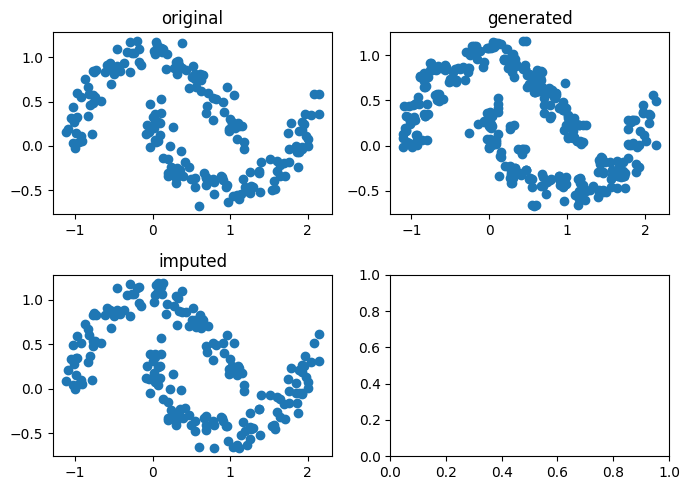

In [28]:
from sklearn.utils.deprecation import _deprecate_Xt_in_inverse_transform
from sklearn.utils.validation import (
    _check_feature_names_in,
    _check_sample_weight,
    check_array,
    check_is_fitted,
)
class KBinsDiscretizerSampler(KBinsDiscretizer):
    def inverse_transform_sample(self, X=None, random_state=None):
        rng = check_random_state(random_state)
        check_is_fitted(self)

        if "onehot" in self.encode:
            X = self._encoder.inverse_transform(X)

        Xinv = check_array(X, copy=True, dtype=(np.float64, np.float32))
        n_features = self.n_bins_.shape[0]
        if Xinv.shape[1] != n_features:
            raise ValueError(
                "Incorrect number of features. Expecting {}, received {}.".format(
                    n_features, Xinv.shape[1]
                )
            )
        n = X.shape[0]
        for jj in range(n_features):
            jitter = rng.uniform(0., 1., size=n)
            bin_edges = self.bin_edges_[jj]
            bin_centers = (bin_edges[1:] + bin_edges[:-1]) * 0.5
            bin_lefts = bin_edges[1:][(Xinv[:, jj]).astype(np.int64)]
            bin_rights = bin_edges[:-1][(Xinv[:, jj]).astype(np.int64)]
            Xinv[:, jj] = bin_lefts * jitter + bin_rights * (1 - jitter)

        return Xinv
class MaskingTreesModel:
    def __init__(
        self,
        n_bins=5,
        duplicate_K=50,
        random_state = None
    ):
        self.n_bins = n_bins
        self.duplicate_K = duplicate_K
        self.random_state = random_state
        self.xgbers_ = None
        self.quantizers_ = None
        self.X_ = None
    def fit(
        self,
        X,
    ):
        # TODO - handle categorical columns
        # TODO - xgboost iterator - generate batches on the fly
        # TODO - xgboost kwargs
        # TODO - sample_weight from OADM formula
        # TODO - KDITransformer
        # TODO - nucleus sampling
        n_samples, n_dims = X.shape
        self.X_ = X.copy()
        self.quantizers_ = []
        rng = check_random_state(self.random_state)
        
        for d in range(n_dims):
            curq = KBinsDiscretizerSampler(
                n_bins=self.n_bins, encode='ordinal', strategy='quantile')
            curq.fit(X[~np.isnan(X[:, d]), d:d+1])
            self.quantizers_.append(curq)

        X_train = []
        Y_train = []
        for dupix in range(self.duplicate_K):
            mask_ixs = np.repeat(np.arange(n_dims)[np.newaxis, :], n_samples, axis=0)
            mask_ixs = np.apply_along_axis(rng.permutation, axis=1, arr=mask_ixs) # n_samples, n_dims
            for n in range(n_samples):
                fuller_X = X[n, :]
                for d in range(n_dims):
                    victim_ix = mask_ixs[n, d]
                    if fuller_X[victim_ix] != np.nan:
                        emptier_X = fuller_X.copy()
                        emptier_X[mask_ixs[n, d]] = np.nan
                        X_train.append(emptier_X.reshape(1, -1))
                        Y_train.append(fuller_X.reshape(1, -1))
                        fuller_X = emptier_X
        X_train = np.concatenate(X_train, axis=0)
        Y_train = np.concatenate(Y_train, axis=0)
        self.trees_ = []
        for d in range(n_dims):
            xgber = xgb.XGBClassifier(tree_method="hist") # TODO: early_stopping_rounds=2)
            train_ixs = ~np.isnan(Y_train[:, d])
            curY_train = self.quantizers_[d].transform(Y_train[train_ixs, d:d+1])        
            curX_train = X_train[train_ixs, :] 
            xgber.fit(curX_train, curY_train)  # TODO: sample_weight
            self.trees_.append(xgber)
        return self

    def generate(
        self,
        n_samples=1,
    ):
        n_samples, n_dims = self.X_.shape
        rng = check_random_state(self.random_state)

        X = np.full(fill_value=np.nan, shape=(n_samples, n_dims))
        unmask_ixs = np.repeat(np.arange(n_dims)[np.newaxis, :], n_samples, axis=0)  # (n_samples, n_dims)
        unmask_ixs = np.apply_along_axis(rng.permutation, axis=1, arr=unmask_ixs) # (n_samples, n_dims)
        for n in range(n_samples):
            for dix in range(n_dims):
                unmask_ix = unmask_ixs[n, dix]
                pred_probas = self.trees_[unmask_ix].predict_proba(X[[n], :])
                pred_quant = rng.choice(self.n_bins, size=(1, 1), p=pred_probas.ravel())
                pred_val = self.quantizers_[unmask_ix].inverse_transform_sample(pred_quant)
                X[n, unmask_ix] = pred_val.item()
        return X

    def impute(
        self,
        k=1,
    ):
        (n_samples, n_dims) = self.X_.shape
        rng = check_random_state(self.random_state)

        imputedX = np.repeat(self.X_[np.newaxis, :, :], repeats=k, axis=0) # (k, n_samples, n_dims)           
        for n in range(n_samples):
            to_unmask = np.where(np.isnan(self.X_[n, :]))[0] # (n_to_unmask,)
            unmask_ixs = np.repeat(to_unmask[np.newaxis, :], k, axis=0)  # (k, n_to_unmask)
            unmask_ixs = np.apply_along_axis(rng.permutation, axis=1, arr=unmask_ixs) # (k, n_to_unmask)
            n_to_unmask = unmask_ixs.shape[1]
            for kix in range(k):
                for dix in range(n_to_unmask):
                    unmask_ix = unmask_ixs[kix, dix]
                    pred_probas = self.trees_[unmask_ix].predict_proba(imputedX[kix,[n], :])
                    pred_quant = rng.choice(self.n_bins, size=(1, 1), p=pred_probas.ravel())
                    pred_val = self.quantizers_[unmask_ix].inverse_transform_sample(pred_quant)
                    imputedX[kix, n, unmask_ix] = pred_val.item()
        return imputedX

rix = 0
rng = check_random_state(rix)
n_upper = 100
n_lower = 100
n = n_upper + n_lower
data, labels = skd.make_moons(
    (n_upper, n_lower), shuffle=False, noise=0.1, random_state=rix)
data4impute = data.copy()
data4impute[:, 1] = np.nan
X=np.concatenate([data, data4impute], axis=0)

model = MaskingTreesModel(n_bins=20)
model.fit(X)
data_fake = model.generate(n_samples=200);



nimp = 1 # number of imputations needed
data_impute = model.impute(k=nimp)[0, :, :]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5));
axes[0, 0].scatter(data[:, 0], data[:, 1]);
axes[0, 0].set_title('original');
axes[0, 1].scatter(data_fake[:, 0], data_fake[:, 1]);
axes[0, 1].set_title('generated');
axes[1, 0].scatter(data_impute[200:, 0], data_impute[200:, 1]);
axes[1, 0].set_title('imputed');
"""
axes[1, 1].scatter(data_impute[200:, 0], data_impute[200:, 1]);
axes[1, 1].set_title('imputed - repainted');
"""
plt.tight_layout();

